In [55]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from typing import List


## Bear Image

In [56]:
# LOAD IMAGE
PATH = 'bear.jpg'
with Image.open(PATH) as img:
    img = np.array(img)
    print(f'Image resolution: {img.shape}')
    img_height=img.shape[0]
    img_width=img.shape[1]

    print(f'Image pixel range: [{img.min()}-{img.max()}]')

Image resolution: (289, 400, 3)
Image pixel range: [0-255]


In [57]:
# show image
def show_images(imgs:List):
    fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(12,6))
    for i, img in enumerate(imgs):
        ax[i].imshow(img)

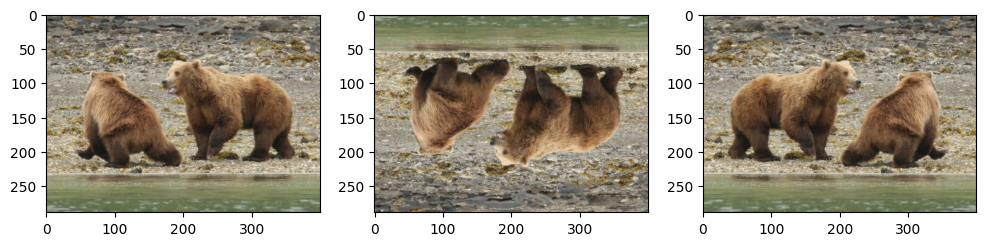

In [58]:
aug1  = A.VerticalFlip(p=1)
aug2  = A.HorizontalFlip(p=1)

show_images(imgs=[
    img, 
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

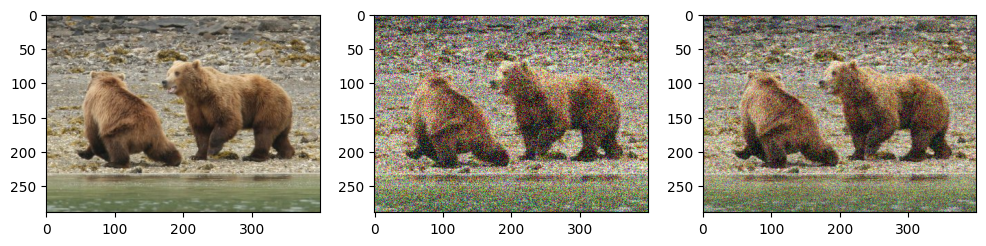

In [59]:
# Gaussian Noise (RANDOM DISTRIBUTION !!! )

'''var_limit=(min, max) defines range for variance (randomly sampled)'''
aug1 = A.GaussNoise(p=1, var_limit=10000)           # min = 10 (default), max = 10000   
aug2 = A.GaussNoise(p=1, var_limit=(1000, 10000))   # min = 1000, max = 10000 ---> should be more noisy  

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])


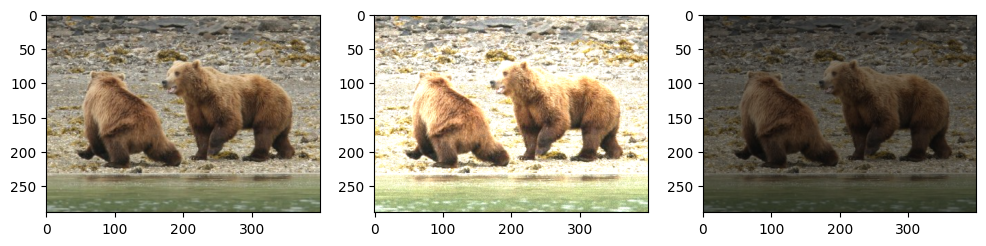

In [60]:
aug1  = A.MultiplicativeNoise(p=1, multiplier=(1.5, 1.75),  elementwise=True) # make lighter (> 1) by random factor (for each pixel individual, since elemetwise=True)
aug2  = A.MultiplicativeNoise(p=1, multiplier=0.5) # make darker (< 1) by fixed factor for all pixels

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

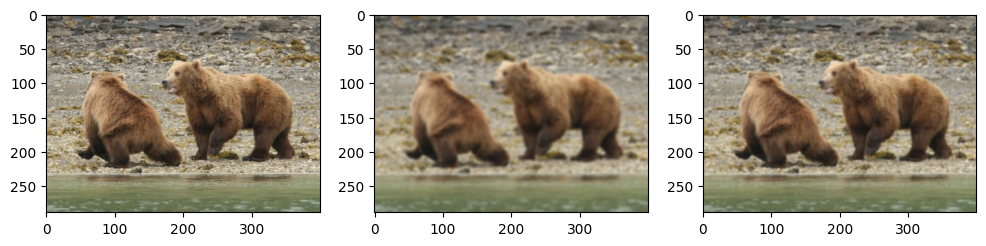

In [61]:
aug1  = A.GaussianBlur(p=1, sigma_limit=(0, 200), always_apply=True)
aug2  = A.GaussianBlur(p=1, sigma_limit=(100, 200), always_apply=True)

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

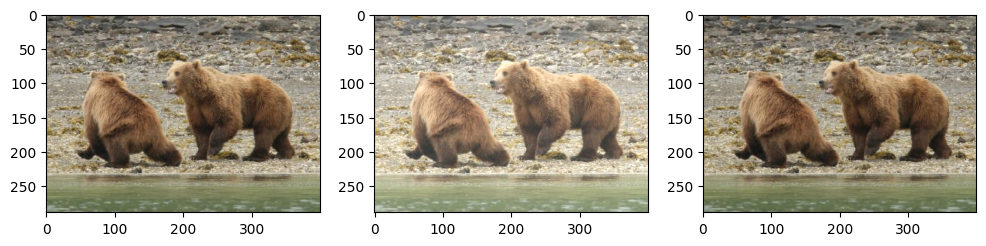

In [62]:
aug1  = A.RandomBrightnessContrast(p=1,brightness_limit=0.5, contrast_limit=0)
aug2  = A.RandomBrightnessContrast(p=1,brightness_limit=0, contrast_limit=0.75)


show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

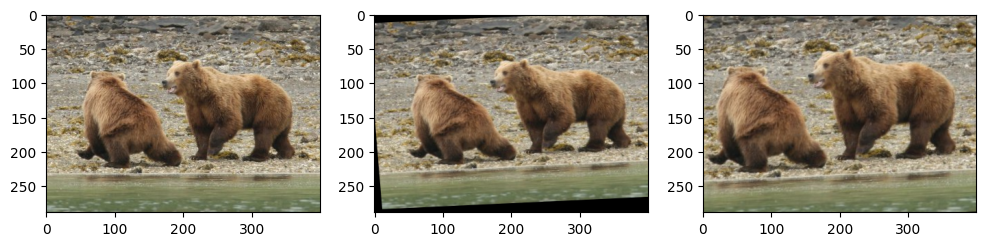

In [63]:
aug1 = A.Affine(
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=0.0,
        shear=(-5, 5),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        p=1.0
    )

aug2 = A.Affine(
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=0.0,
        shear=(-5, 5),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        p=1.0
    )

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

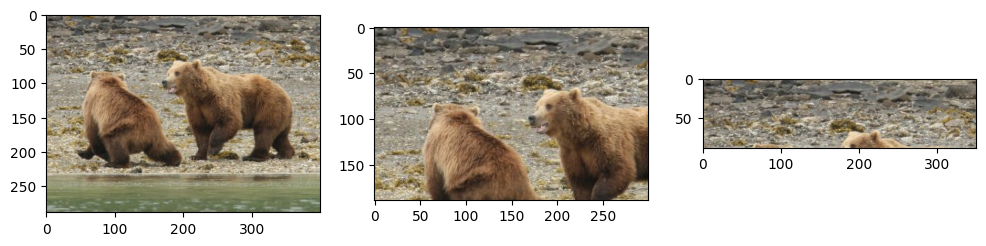

In [64]:
aug1 = A.Crop(
    x_min=0,
    y_min=0,
    x_max=img_width - 100,
    y_max=img_height - 100,
    p=1.0)

aug2 = A.Crop(
    x_min=0,
    y_min=0,
    x_max=img_width - 50,
    y_max=img_height - 200,
    p=1.0)

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])

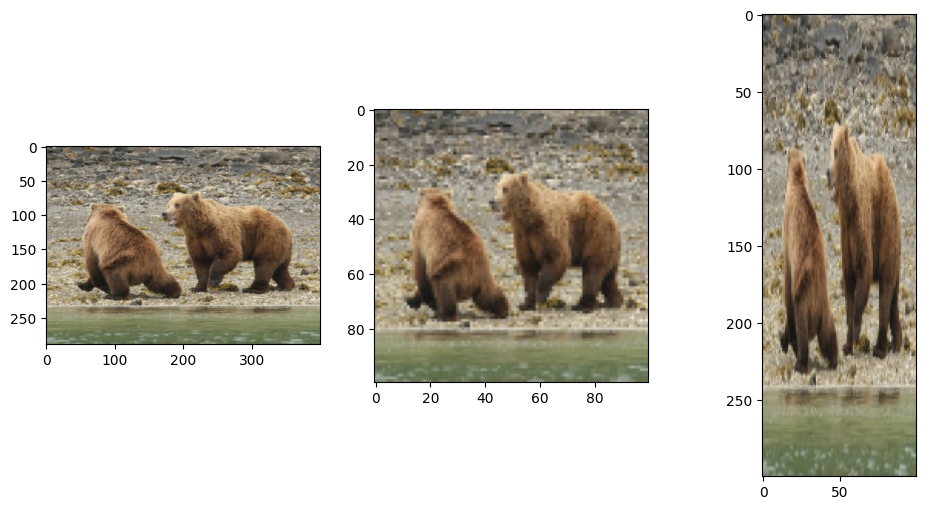

In [65]:
aug1 = A.Resize(
    height=100,
    width=100,
    p=1.0,
)

aug2 = A.Resize(
    height=300,
    width=100,
    p=1.0,
)

show_images(imgs=[
    img,
    aug1(image=img)['image'],
    aug2(image=img)['image']
])